In [2]:
import argparse
import ast
import gc
import h5py
import nd2
import os

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_h5(path, channels_to_load=None):
    with h5py.File(path, "r") as hdf5_file:
        data = hdf5_file["dataset"]

        # Select channels if channels_to_load is provided
        if channels_to_load is not None:
            data = data[:, :, channels_to_load].squeeze()
        else:
            data = data[:,:,:]

    return data

In [4]:
img_file = '/hpcnfs/scratch/P_DIMA_ATTEND/imaging/nd2conversion/work/f7/56f96e80940746c3e2f17582a09f35/19S30_DAPI_ARID1A_PDL1.h5'

img = load_h5(img_file)

In [269]:
!pip install dipy

  Obtaining dependency information for dipy from https://files.pythonhosted.org/packages/30/45/eef3447d428212acf1a2738bb8e9b77c86f3f0d5d368a8e3b2767dd722e8/dipy-1.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for nibabel>=3.0.0 from https://files.pythonhosted.org/packages/43/b2/dc384197be44e2a640bb43311850e23c2c30f3b82ce7c8cdabbf0e53045e/nibabel-5.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for trx-python>=0.2.9 from https://files.pythonhosted.org/packages/57/3b/fe226b78c9e2fa501a3115d132832aee9a6a08e16692fbd9f237a4e99e3e/trx_python-0.3-py3-none-any.whl.metadata
  Obtaining dependency information for setuptools-scm from https://files.pythonhosted.org/packages/a0/b9/1906bfeb30f2fc13bb39bf7ddb8749784c05faadbd18a21cf141ba37bff2/setuptools_scm-8.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for deepdiff from https://files.pythonhosted.org/packages/06/46/01673060e83277a863baf0909b387cd809865cb

In [8]:
import psutil

def memory_usage():
    """Check the memory usage of the current Jupyter Notebook process."""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    memory_in_mb = mem_info.rss / (1024 * 1024)  # Convert bytes to MB
    print(f"Current memory usage: {memory_in_mb:.2f} MB")

In [22]:
memory_usage()

Current memory usage: 20742.90 MB


In [31]:
import numpy as np

def create_crops(image, crop_size, overlap_size):
    """
    Create overlapping crops from a 3D image.
    
    Args:
        image (numpy.ndarray): The input image of shape (X, Y, Z) with dtype uint16.
        crop_size (int): The size of the crops along X and Y (a x a).
        overlap_size (int): The overlap size along X and Y.
    
    Returns:
        list: A list of crops of shape (a, a, Z).
        list: A list of the top-left corner indices of each crop.
    """
    X, Y, Z = image.shape
    a = crop_size
    crops = []
    positions = []
    
    for x in range(0, X, a - overlap_size):
        for y in range(0, Y, a - overlap_size):
            # Ensure crop dimensions don't exceed the image dimensions
            x_end = min(x + a, X)
            y_end = min(y + a, Y)
            crop = image[x:x_end, y:y_end, :]
            crops.append(crop)
            positions.append((x, y))
    
    return crops, positions


def reconstruct_image(crops, positions, original_shape, crop_size, overlap_size):
    """
    Reconstruct the original image from overlapping crops.
    
    Args:
        crops (list): List of crops.
        positions (list): List of top-left corner indices for each crop.
        original_shape (tuple): Shape of the original image (X, Y, Z).
        crop_size (int): The size of the crops along X and Y.
        overlap_size (int): The overlap size along X and Y.
    
    Returns:
        numpy.ndarray: The reconstructed image of dtype uint16.
    """
    X, Y, Z = original_shape
    reconstructed = np.zeros(original_shape, dtype=img.dtype)  # Use uint16 for intermediate sums
    

    for crop, (x, y) in zip(crops, positions):

        # Shape crops
        c_x, c_y, _ = crop.shape
        # border
        if y == 0:
            y_start = y
            y_end = y + crop.shape[1] - overlap_size // 2 
            crop = crop[:, :(crop.shape[1] - overlap_size // 2 ), :]
            
        elif y == Y - c_y: # border
            y_start = y + overlap_size // 2
            y_end = y + crop.shape[1]
            crop = crop[:, (overlap_size // 2):, :]
        else: # no border
            y_start = y + overlap_size // 2
            y_end = y + crop.shape[1] - overlap_size // 2 
            crop = crop[:, (overlap_size // 2):(crop.shape[1] - overlap_size // 2 ), :]

        # border
        if x == 0:
            x_start = x
            x_end = x + crop.shape[0] - overlap_size // 2 
            crop = crop[:(crop.shape[0] - overlap_size // 2 ), :, :]
        elif x == X - c_x: # border
            x_start = x + overlap_size // 2
            x_end = x + crop.shape[0]
            crop = crop[(overlap_size // 2):, :, :]
        else: # no border
            x_start = x + overlap_size // 2
            x_end = x + crop.shape[0] - overlap_size // 2 
            crop = crop[(overlap_size // 2):(crop.shape[0] - overlap_size // 2 ), :, :]
        reconstructed[x_start:x_end, y_start:y_end, :] += crop
    
    # Convert back to uint16
    return reconstructed


In [261]:
import numpy as np

def create_crops(image, crop_size, overlap_size):
    """
    Create overlapping crops from a 3D image.
    
    Args:
        image (numpy.ndarray): The input image of shape (X, Y, Z) with dtype uint16.
        crop_size (int): The size of the crops along X and Y (a x a).
        overlap_size (int): The overlap size along X and Y.
    
    Returns:
        list: A list of crops of shape (a, a, Z).
        list: A list of the top-left corner indices of each crop.
    """
    X, Y, Z = image.shape
    crops = []
    positions = []
    
    for x in range(0, X - overlap_size, crop_size - overlap_size):
        for y in range(0, Y - overlap_size, crop_size - overlap_size):
            # Ensure crop dimensions don't exceed the image dimensions
            x_end = min(x + crop_size, X)
            y_end = min(y + crop_size, Y)
            crop = image[x:x_end, y:y_end, :]
            crops.append(crop)
            positions.append((x, y))
    
    return crops, positions


def reconstruct_image(crops, positions, original_shape, crop_size, overlap_size):
    """
    Reconstruct the original image from overlapping crops.
    
    Args:
        crops (list): List of crops.
        positions (list): List of top-left corner indices for each crop.
        original_shape (tuple): Shape of the original image (X, Y, Z).
        crop_size (int): The size of the crops along X and Y.
        overlap_size (int): The overlap size along X and Y.
    
    Returns:
        numpy.ndarray: The reconstructed image of dtype uint16.
    """
    X, Y, Z = original_shape
    reconstructed = np.zeros(original_shape, dtype=img.dtype)  # Use uint16 for intermediate sums
    

    for crop, (x, y) in zip(crops, positions):

        # Shape crops
        c_x, c_y, _ = crop.shape
        # border
        if y == 0:
            y_start = y
            y_end = y + crop.shape[1] - overlap_size // 2 
            crop = crop[:, :(crop.shape[1] - overlap_size // 2 ), :]
            
        elif y == Y - c_y: # border
            y_start = y + overlap_size // 2
            y_end = y + crop.shape[1]
            crop = crop[:, (overlap_size // 2):, :]
            
        else: # no border
            y_start = y + overlap_size // 2
            y_end = y + crop.shape[1] - overlap_size // 2 
            crop = crop[:, (overlap_size // 2):(crop.shape[1] - overlap_size // 2 ), :]

        # border
        if x == 0:
            x_start = x
            x_end = x + crop.shape[0] - overlap_size // 2 
            crop = crop[:(crop.shape[0] - overlap_size // 2 ), :, :]
        elif x == X - c_x: # border
            x_start = x + overlap_size // 2
            x_end = x + crop.shape[0]
            crop = crop[(overlap_size // 2):, :, :]
        else: # no border
            x_start = x + overlap_size // 2
            x_end = x + crop.shape[0] - overlap_size // 2 
            crop = crop[(overlap_size // 2):(crop.shape[0] - overlap_size // 2 ), :, :]
        reconstructed[x_start:x_end, y_start:y_end, :] += crop
    
    # Convert back to uint16
    return reconstructed


In [263]:
%%time
crop_size = 500
overlap_size = 200

crops, positions = create_crops(img_crop, crop_size, overlap_size)


# Example usage
reconstructed_image = reconstruct_image(
    crops, positions, original_shape=img_crop.shape, crop_size=crop_size, overlap_size=overlap_size
)

# Check the reconstruction
print(f"Reconstructed image shape: {reconstructed_image.shape}")

Reconstructed image shape: (11000, 11000, 3)
CPU times: user 334 ms, sys: 373 ms, total: 707 ms
Wall time: 705 ms


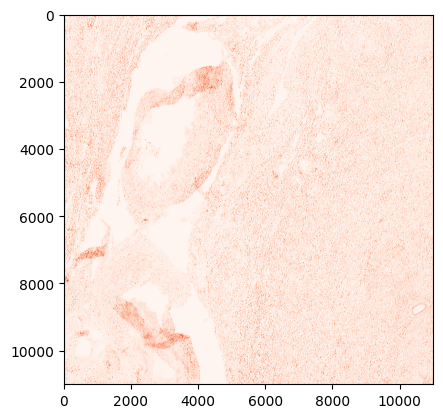

In [234]:
img_crop = img[12000:23000,12000:23000,:]

plt.imshow(img_crop[:,:,2], cmap="Reds")

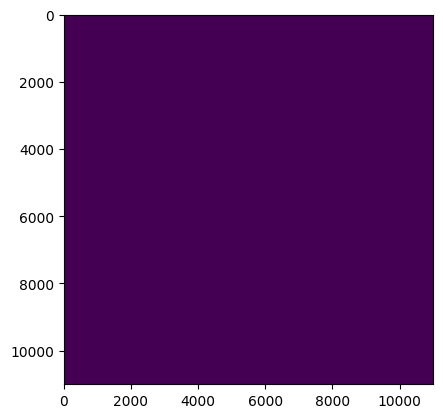

In [264]:
plt.imshow((reconstructed_image - img_crop)[:,:,0].squeeze())

In [265]:
(reconstructed_image[:,:,1] == img_crop[:,:,1]).all()

True

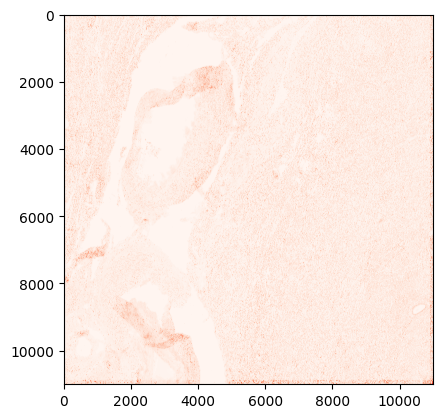

In [241]:
plt.imshow(reconstructed_image[:,:,2], cmap="Reds")

In [215]:
np.quantile(reconstructed_image, 0.2)

609.0

In [214]:
np.quantile(img_crop, 0.2)

609.0

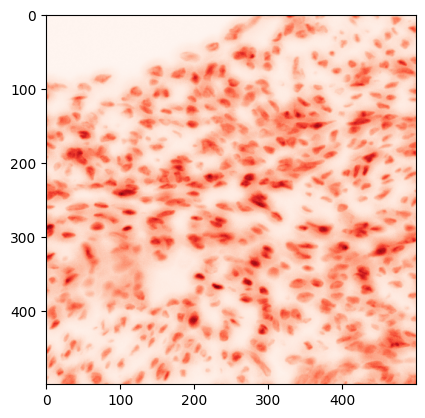

In [137]:
plt.imshow(crops[0][:,:,2], cmap="Reds")

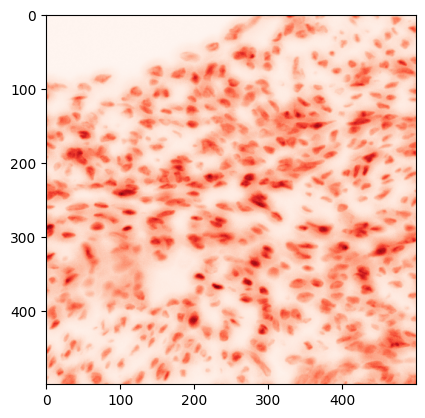

In [138]:
plt.imshow(img_crop[:500,:500,2], cmap="Reds")

In [158]:
reconstructed_image 

array([[[ 651,  621,  117],
        [ 563,  678,  112],
        [ 541,  714,  118],
        ...,
        [ 699,  883, 1404],
        [ 578,  913, 1430],
        [ 615,  867, 1130]],

       [[ 559,  614,  129],
        [ 549,  587,  108],
        [ 663,  752,  128],
        ...,
        [ 674,  908, 1292],
        [ 597,  861, 1187],
        [ 632,  787, 1164]],

       [[ 561,  737,  118],
        [ 571,  642,  113],
        [ 576,  640,  117],
        ...,
        [ 542,  962, 1172],
        [ 634,  844, 1119],
        [ 670,  898, 1106]],

       ...,

       [[ 565,  676,  131],
        [ 561,  596,  135],
        [ 595,  664,  134],
        ...,
        [ 592,  667,  164],
        [ 607,  664,  177],
        [ 633,  709,  165]],

       [[ 555,  570,  128],
        [ 648,  629,  147],
        [ 578,  735,  133],
        ...,
        [ 576,  673,  179],
        [ 492,  545,  201],
        [ 596,  651,  179]],

       [[ 564,  649,  125],
        [ 534,  669,  138],
        [ 545,  

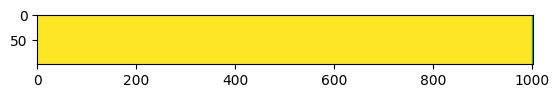

In [176]:
plt.imshow((reconstructed_image[100:200,3000:4002, 2] == img_crop[100:200,3000:4002,2]))

In [206]:
a = (reconstructed_image - img_crop)[:,:,2].squeeze()

In [208]:
np.unique(a)

array([    0,    96,    99, ..., 26436, 26739, 27006], dtype=uint16)

In [209]:
reconstructed_image[a == 96]

array([[1096, 1356,  192]], dtype=uint16)

In [210]:
img_crop[a == 96]

array([[548, 678,  96]], dtype=uint16)

In [170]:
x

np.sum(reconstructed_image[:2000,:1000, 1] - img_crop[:,:, 1])

107165200

In [268]:
assert img_crop.shape != img_crop.shape

AssertionError: 